In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.collections import LineCollection
%matplotlib inline


goldenRatio = (1 + math.sqrt(5)) / 2
degree_to_rad = lambda d : d / 180.0 * math.pi

In [2]:
def make_isosceles_triangle(alpha, base, kind):
    # alpha in radials!
    Cy = base / 2 / math.tan( alpha )
    A = 0
    B = - base / 2 - Cy * 1j
    C =   base / 2 - Cy * 1j
    return (kind, A, B, C)

def translate(triangle, translation):
    kind, A, B, C = triangle
    A += translation
    B += translation
    C += translation
    return (kind, A, B, C)

def scale(triangle, scaling):
    kind, A, B, C = triangle
    A *= scaling
    B *= scaling
    C *= scaling
    return (kind, A, B, C)

def point_in_range(P, xlim, ylim):
    if P.real > xlim[0] and P.real < xlim[1]:
        if P.imag > ylim[0] and P.imag < ylim[1]:
            return True
    return False

def triangle_in_range(triangle, xlim, ylim):
    """
    Check if triangle is in a interval.
    Returns:
        - 1 if triangle is completely in interval
        - 0 if triangle is completely outside interval
        - 0.5 if triangle is partially in interval
    """
    in_range = [point_in_range(P, xlim, ylim) for P in triangle[1:]]
    if all(in_range):
        return 1
    elif any(in_range):
        return 0.5
    else:
        return 0
    
def tuples_to_coordinates(triangles):
    coordinates = np.zeros((len(triangles), 3, 2))
    colors = []
    for i, (color, A, C, B) in enumerate(triangles):
        colors.append(color)
        coordinates[i, :, 0] = map(lambda x : x.real, [A, B, C])
        coordinates[i, :, 1] = map(lambda x : x.imag, [A, B, C])
    return coordinates, colors

In [3]:
def subdivide(triangles):
    result = []
    for (kind, A, B, C) in triangles:
        if kind == 0:  # half kite
            P = ( C + A * goldenRatio ) / (1 + goldenRatio)
            Q = ( A + B * goldenRatio ) / (1 + goldenRatio)
            result += [(1, P, A, Q), (0, C, Q, P), (0, C, Q, B)]
        if kind == 1:  # half dart
            P = (B + C * goldenRatio) / (1 + goldenRatio)
            result += [(1, P, C, A), (0, B, A, P)]
    return result

In [4]:
def make_kite():
    alpha = degree_to_rad(36)
    return [(0, 0, 1, math.cos(alpha) + 1j * math.sin(alpha)), (0, 0, 1, math.cos(alpha) - 1j * math.sin(alpha))]

def make_dart():
    alpha = degree_to_rad(108)
    return [(1, 0, 1, math.cos(alpha) + 1j*math.sin(alpha)), (1, 0, 1, math.cos(alpha) - 1j*math.sin(alpha))]

def make_sun():
    result = []
    alpha = degree_to_rad(36)
    rotation = 2 * math.pi / 5
    for i in range(5):
        B = math.cos(rotation * i) + 1j * math.sin(rotation * i)
        C1 = math.cos(alpha + rotation * i) + 1j * math.sin(alpha + rotation * i)
        C2 = math.cos(- alpha + rotation * i) + 1j * math.sin(- alpha + rotation * i)
        result += [(0, 0, B, C1), (0, 0, B, C2)]
    return result

def make_star():
    result = []
    alpha = degree_to_rad(36)
    rotation = 2 * math.pi / 5
    for i in range(5):
        A = math.cos(rotation * i) + 1j * math.sin(rotation * i)
        B = 0
        C1 = goldenRatio * math.cos(alpha + rotation * i) + goldenRatio * 1j * math.sin(alpha + rotation * i)
        C2 = goldenRatio * math.cos(- alpha + rotation * i) + goldenRatio * 1j * math.sin(- alpha + rotation * i)
        result += [(1, A, B, C1), (1, A, B, C2)]
    return result

def make_ace():
    A = 1j
    B = 0
    C = - goldenRatio * 1j
    E = math.cos( -0.1 * math.pi) + 1j * math.sin( -0.1 * math.pi)
    D = C + goldenRatio * (math.cos( 0.1 * math.pi ) + 1j * math.sin( 0.1 * math.pi ))
    right_half = [(0, C, E, B), (0, C, E, D), (1, B, A, E)]
    left_half = [(0, C, -E.conjugate(), B), (0, C, -E.conjugate(), -D.conjugate()), (1, B, A, -E.conjugate())]
    return right_half + left_half

Need about 30192.0 kites
Need about 18657.0 kites


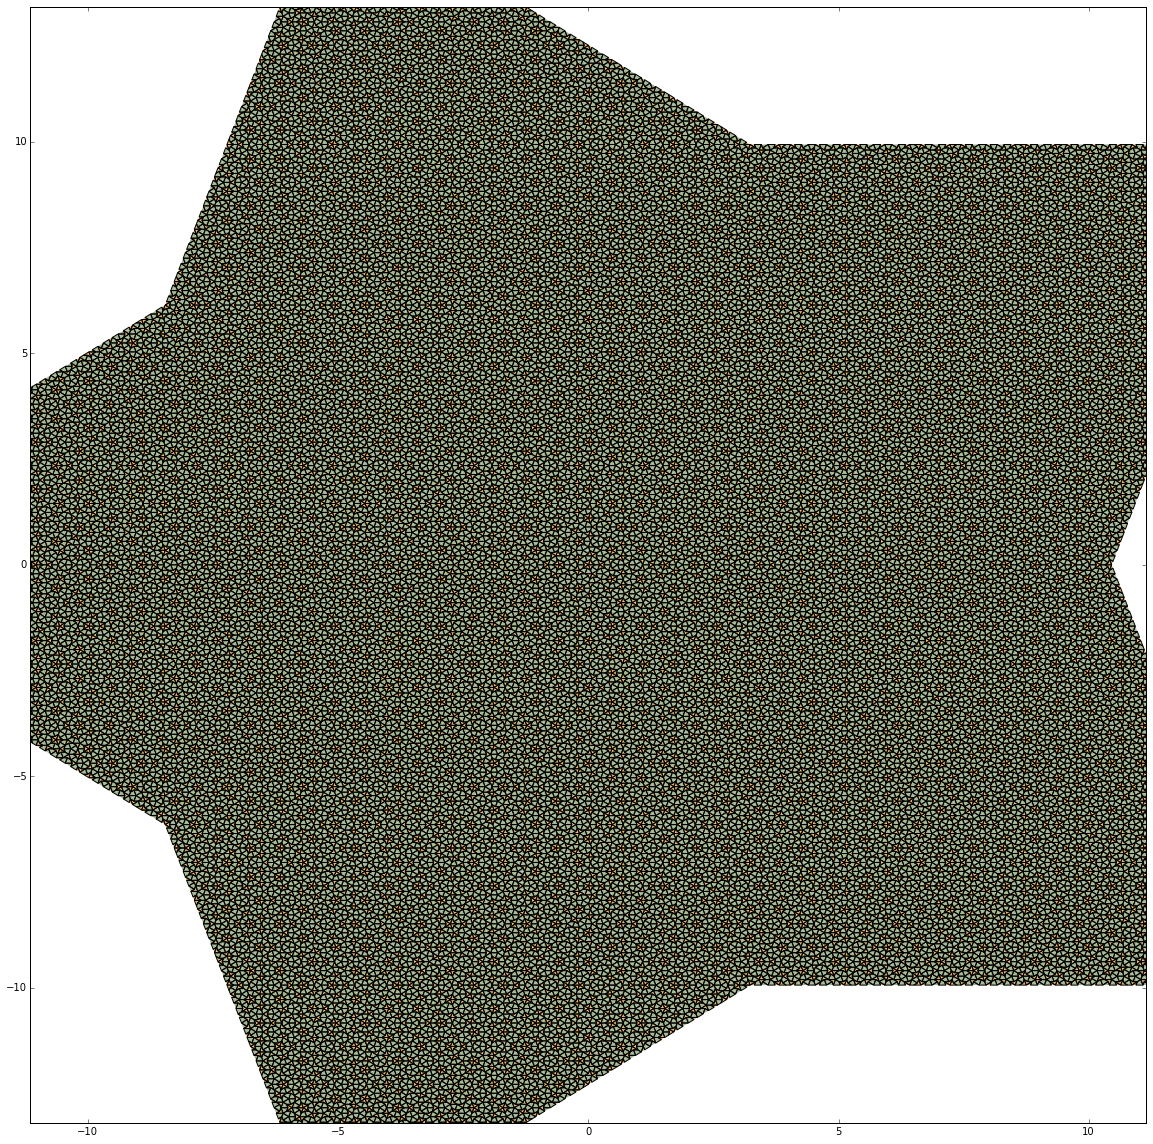

In [32]:
# parameters to tune
length_long_side = 0.085*goldenRatio
width = 2.23
length = 2.64
kite_color = map(lambda x : x /255.0, (226, 178, 99))
dart_color = map(lambda x : x /255.0, (160, 180, 141))
n_iterations = 7
start_fig = make_star()

limit_check = lambda tr : triangle_in_range(tr, (-width/2, width/2), (-length/2, length/2))

# calculate figures
triangles = start_fig
for subdiv in range(n_iterations):
    triangles = subdivide(triangles)

# scale
kind, A, B, C = triangles[0]
current_length = max(abs(A-B) , abs(B-C))
triangles = map(lambda tr : scale(tr, length_long_side/current_length), triangles)

# plot figures
coord_tr, colors = tuples_to_coordinates(triangles)

poly_collection = PolyCollection(coord_tr, facecolors=[kite_color if c is 1 else dart_color for c in colors], linewidths=0)
edge_collection = LineCollection(coord_tr, colors='k')

fig, ax = plt.subplots(figsize=(20,20))
ax.add_collection(poly_collection)
ax.add_collection(edge_collection)
ax.set_xlim(-width/2, width/2)
ax.set_ylim(-length/2, length/2)
ax.autoscale_view()



kites_complete = filter(lambda x : x[0] is 0 and limit_check(x) > 0, triangles)
darts_complete = filter(lambda x : x[0] is 1 and limit_check(x) > 0, triangles)

print 'Need about %s kites' %(len(kites_complete) * 0.5)
print 'Need about %s kites' %(len(darts_complete) * 0.5)

fig.savefig('Penrose_tiling_75060_75080.jpg')